# Using image classification to label plant species
Firstly, importing all necessary packages needed and setting some plot style preferences.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2

In [2]:
plt.rcParams['figure.figsize'] = (21.0, 13.0)
plt.rcParams['font.size'] = 18.0
sns.set_style('darkgrid')
sns.set_palette('pastel')

As I have access to a GPU on my PC I will quickly check if TensorFlow is able to find it.

In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


That all checks out. Now we can pre-process the multi-labeled image data downloaded from the [Kaggle competition page](https://www.kaggle.com/c/plant-seedlings-classification/overview). Firstly, we need to check how many different plant labels we have to begin with, as this will define the set of all classification labels that can possibly be assigned by our model. The image data available under $\texttt{train.zip}$ has the labels of the plant species as the name of the subdirectory containing the images of that plant species, so we can list all subdirectories of the data to see all classification labels and save as a Python list.

In [4]:
species_list = os.listdir('./train')
species_list

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

Then we can consider constructing a coherent pre-pixel data set which contains the plant species label as the first column, the numerical plant species label as the second column and the image file location as the third column. This is done for ease of further use of the data in that we won't need to deal with constantly going into each of the above subdirectories of the data. After some research into how this can be done, I found the following to be the most straight forward method to iteratively go through each file in each subdirectory while keeping track of the subdirectory label. Note that we also setup the resized image file name as this will be created in the next couple of steps.

In [5]:
full_data = list()
for numerical_species, species in enumerate(species_list):
    for file_name in os.listdir(os.path.join('./train', species)):
        full_data.append([species, numerical_species, './train/{}/{}'.format(species, file_name), './pre_processed_train/{}/{}'.format(species, file_name)])
full_data = pd.DataFrame(full_data, columns=['species', 'numerical_species', 'file_name', 'pre_processed_file_name'])
full_data.head()

,species,numerical_species,file_name,pre_processed_file_name
0,Black-grass,0,./train/Black-grass/0050f38b3.png,./pre_processed_train/Black-grass/0050f38b3.png
1,Black-grass,0,./train/Black-grass/0183fdf68.png,./pre_processed_train/Black-grass/0183fdf68.png
2,Black-grass,0,./train/Black-grass/0260cffa8.png,./pre_processed_train/Black-grass/0260cffa8.png
3,Black-grass,0,./train/Black-grass/05eedce4d.png,./pre_processed_train/Black-grass/05eedce4d.png
4,Black-grass,0,./train/Black-grass/075d004bc.png,./pre_processed_train/Black-grass/075d004bc.png


We can observe the total image count.

In [6]:
full_data.shape

(4750, 4)

As well as the total number of images in each of the given species.

In [7]:
full_data['species'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: species, dtype: int64

It is important to note that we have only 221 images of two of the plant species when it comes to defining a training/testing data split. As we will need to ensure that a good amount of each plant species is present in the training data for a cohesive prediction model. We can ensure this is done by setting a random seed that has a good data split of the above levels.

Next we can consider the quality of the provided images. After a small look through some of the photos I have noticed that the images vary in size quite a bit. To rectify this we can consider setting a base image size and transform all images to this agreed size. Firstly, we can consider graphing a histogram of all of the image heights and image widths and find the smallest height and width. To do so we can add two more columns to our pre-pixel data which will be the image height and image width.

In [8]:
shape_list = [ cv2.imread(file).shape for file in full_data['file_name'] ]
heights = [ x[0] for x in shape_list ]
widths = [ x[1] for x in shape_list ]
full_data['image_height'] = heights
full_data['image_width'] = widths

In [9]:
full_data.head()

,species,numerical_species,file_name,pre_processed_file_name,image_height,image_width
0,Black-grass,0,./train/Black-grass/0050f38b3.png,./pre_processed_train/Black-grass/0050f38b3.png,196,196
1,Black-grass,0,./train/Black-grass/0183fdf68.png,./pre_processed_train/Black-grass/0183fdf68.png,388,388
2,Black-grass,0,./train/Black-grass/0260cffa8.png,./pre_processed_train/Black-grass/0260cffa8.png,886,886
3,Black-grass,0,./train/Black-grass/05eedce4d.png,./pre_processed_train/Black-grass/05eedce4d.png,117,117
4,Black-grass,0,./train/Black-grass/075d004bc.png,./pre_processed_train/Black-grass/075d004bc.png,471,471


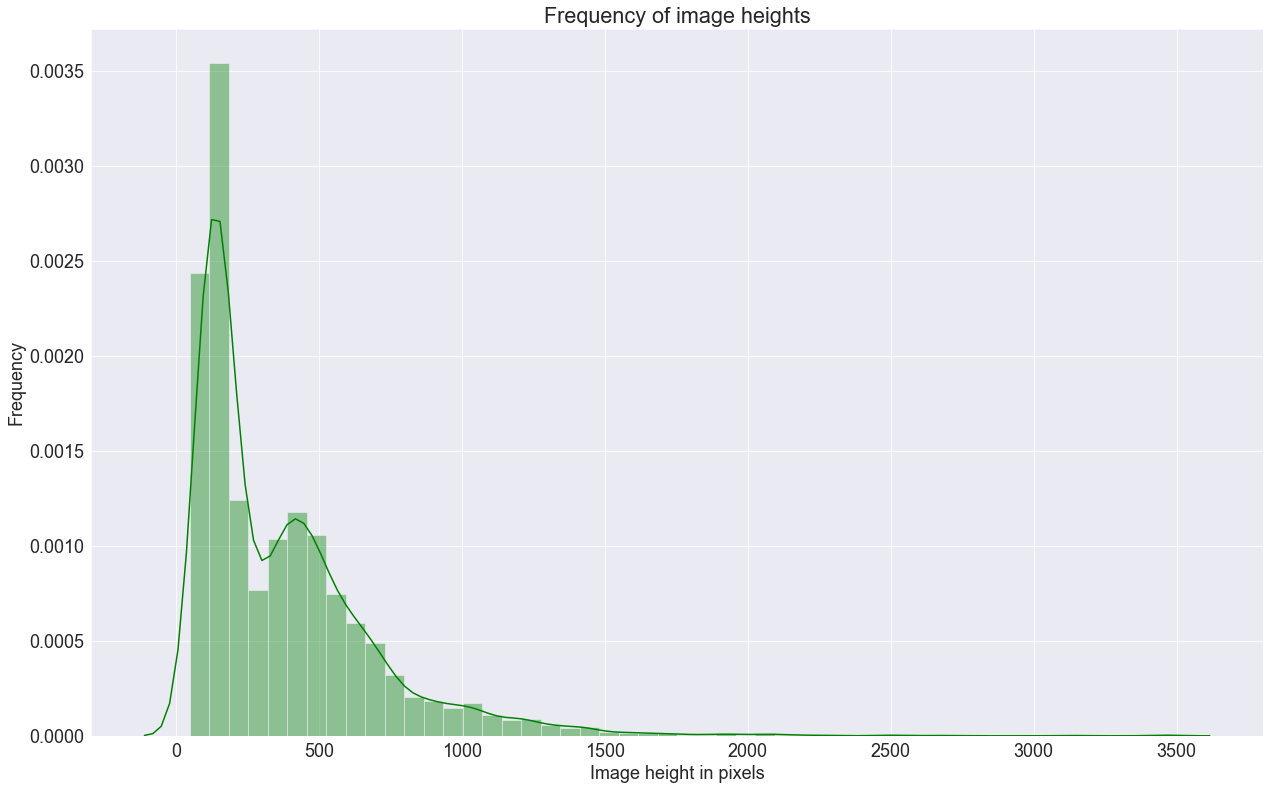

In [10]:
sns.distplot(full_data['image_height'], color = 'green')
plt.title('Frequency of image heights')
plt.ylabel('Frequency')
plt.xlabel('Image height in pixels')
plt.savefig('heights.png');

In [11]:
full_data['image_height'].min()

49

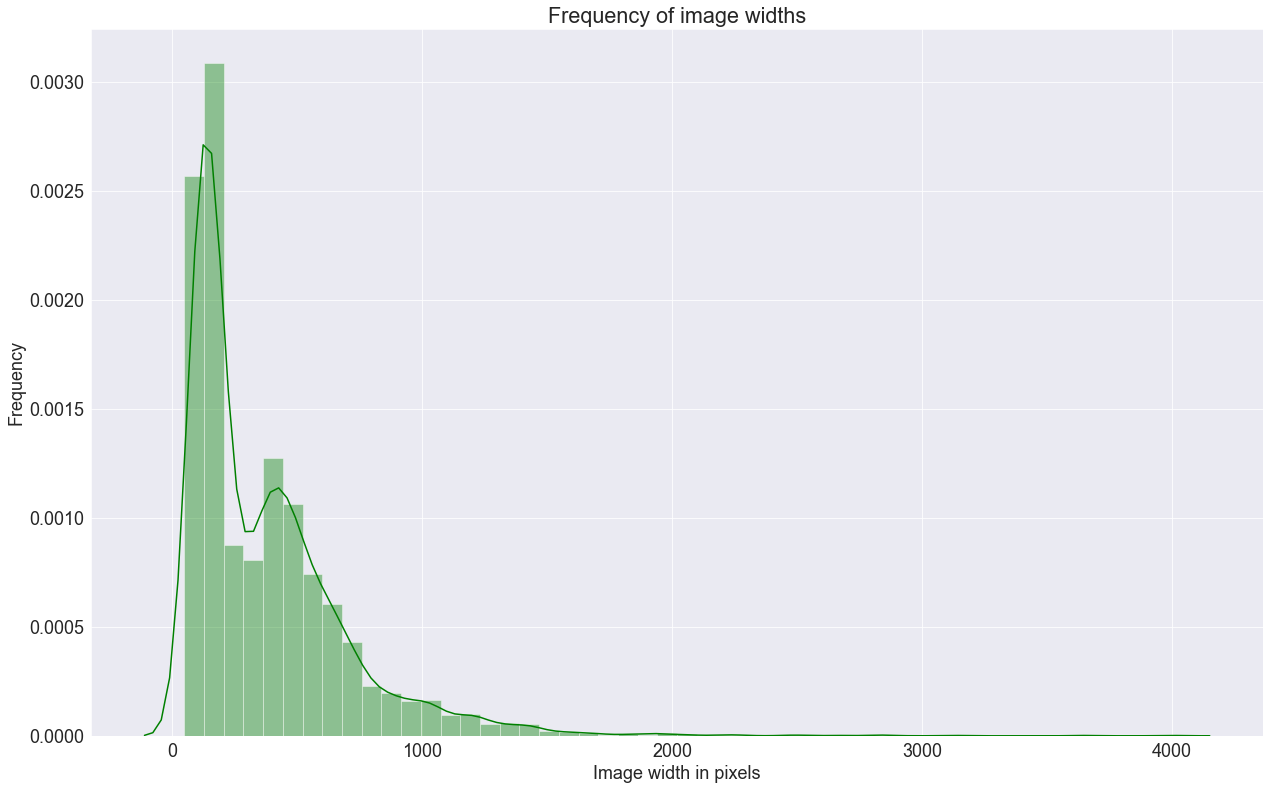

In [12]:
sns.distplot(full_data['image_width'], color = 'green')
plt.title('Frequency of image widths')
plt.ylabel('Frequency')
plt.xlabel('Image width in pixels')
plt.savefig('widths.png');

In [13]:
full_data['image_width'].min()

49

Now as shrinking an image down to a smaller size is a much better task than zooming an image in and interpolating new pixel data, we can select a base image size for our data to be 48 by 48 pixels. As this ensures that no image will be upscaled.

Next, before we resize the image we can do some neat computer vision tricks. After some observation of the data it can be seen that all of these plants are distinctly green and more importantly all of these plants are photographed from the top down to there rocky garden bed. This means that in all of the given images we have a green plant photographed against a non-green background. So we can consider removing these backgrounds from all of the images and just leaving the green plant. One way we can do so is by throwing away all non-green pixels from each image by applying a mask that filters all non-green. This is done prior to resizing so that each resized image has a well defined set of green pixels and is not just plain black.

Another very important issue solved by applying this green mask is that it increases the independence of each image. As we can assume that all of plant species are located in a close proximity to each other. i.e. each photographed plant species is located in the same garden bed. So by removing the background we remove the capability of our (to be constructed) neural network from learning the background of the garden bed of each plant species. This means our model will be much better in identifying the actual plant and not just the plant and environment around the plant. We also add some Gaussian blur to de-noise the image.

In [14]:
os.mkdir('pre_processed_train')
for species in species_list:
    os.mkdir('./pre_processed_train/{}'.format(species))
count = 0
for file in full_data['file_name']:
    image = cv2.imread(file)
    greenmask = cv2.inRange(cv2.cvtColor(image, cv2.COLOR_BGR2HSV), (28, 25, 25), (92, 255, 255))
    green_image = np.zeros_like(image)
    green_image[greenmask > 0] = image[greenmask > 0]
    #Saving an example image for the report
    if(count == 0):
        cv2.imwrite('green_image.png', green_image)
    pre_processed_image = cv2.resize(green_image, (48, 48), interpolation = cv2.INTER_AREA)
    pre_processed_image = cv2.GaussianBlur(pre_processed_image, (5,5), 0)
    pre_processed_file = './pre_processed_train' + file[7:]
    cv2.imwrite(pre_processed_file, pre_processed_image)

Next we sequentially setup our convolutional neural network that be our predictive model for this multi-level classification problem.

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
tf.logging.set_verbosity(tf.logging.ERROR)
convolutional_neural_network = Sequential()
# First layer
convolutional_neural_network.add(Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (48, 48, 3)))
convolutional_neural_network.add(Conv2D(64, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(MaxPooling2D(pool_size = (2, 2)))
convolutional_neural_network.add(BatchNormalization())
convolutional_neural_network.add(Dropout(0.25))

#Second layer
convolutional_neural_network.add(Conv2D(128, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(Conv2D(256, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(MaxPooling2D(pool_size = (2, 2)))
convolutional_neural_network.add(BatchNormalization())
convolutional_neural_network.add(Dropout(0.25))

# Third layer
convolutional_neural_network.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(Conv2D(1024, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(MaxPooling2D(pool_size = (2, 2)))
convolutional_neural_network.add(BatchNormalization())
convolutional_neural_network.add(Dropout(0.25))

# Fourth layer
convolutional_neural_network.add(Conv2D(512, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(Conv2D(1024, kernel_size = (3, 3), padding = 'same', activation = 'relu'))
convolutional_neural_network.add(MaxPooling2D(pool_size = (2, 2)))
convolutional_neural_network.add(BatchNormalization())
convolutional_neural_network.add(Dropout(0.25))

# Final layer
convolutional_neural_network.add(GlobalAveragePooling2D())
convolutional_neural_network.add(Dense(4096, activation = 'relu'))
convolutional_neural_network.add(Dense(4096, activation = 'relu'))
convolutional_neural_network.add(Dense(12, activation = 'softmax'))
convolutional_neural_network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']);

Using TensorFlow backend.


In [16]:
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(full_data, test_size = 0.1, random_state = 0)
training_data['species'].value_counts()

Loose Silky-bent             598
Common Chickweed             551
Scentless Mayweed            458
Small-flowered Cranesbill    450
Fat Hen                      427
Sugar beet                   353
Charlock                     343
Cleavers                     259
Black-grass                  232
Shepherds Purse              204
Common wheat                 201
Maize                        199
Name: species, dtype: int64

In [17]:
from keras.utils.np_utils import to_categorical
X_train = np.array([ cv2.imread(pre_processed_file) for pre_processed_file in training_data['pre_processed_file_name'] ])
y_train = to_categorical(training_data['numerical_species'])
X_test = np.array([ cv2.imread(pre_processed_file) for pre_processed_file in testing_data['pre_processed_file_name'] ])
y_test = to_categorical(testing_data['numerical_species'])

In [18]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(rotation_range = 90, width_shift_range = 0.1, height_shift_range = 0.1,
                                    shear_range = 0.01, zoom_range = [0.75, 1.25], horizontal_flip = True,
                                    vertical_flip = True, fill_mode = 'constant')

In [19]:
convolutional_neural_network.fit_generator(data_generator.flow(X_train, y_train, batch_size = 512), validation_data = (X_test, y_test),
                                          steps_per_epoch = 360*len(X_train)/512, epochs = 5);

Epoch 1/5
3006/3005 [==============================] - 4782s 2s/step - loss: 0.1619 - acc: 0.9415 - val_loss: 0.5875 - val_acc: 0.8884
Epoch 2/5
3006/3005 [==============================] - 4379s 1s/step - loss: 0.0358 - acc: 0.9877 - val_loss: 0.5389 - val_acc: 0.9095
Epoch 3/5
3006/3005 [==============================] - 3920s 1s/step - loss: 0.0205 - acc: 0.9935 - val_loss: 0.4448 - val_acc: 0.9137
Epoch 4/5
3006/3005 [==============================] - 3263s 1s/step - loss: 0.0150 - acc: 0.9956 - val_loss: 0.3722 - val_acc: 0.9453
Epoch 5/5
3006/3005 [==============================] - 3369s 1s/step - loss: 0.0132 - acc: 0.9963 - val_loss: 0.2477 - val_acc: 0.9495
